# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Gradient boosting libraries
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Load Dataset


In [2]:
df = pd.read_csv('HousingData.csv')
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
print("Columns:", df.columns.tolist())

Dataset has 506 rows and 14 columns.
Columns: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


# Fill Missing Values

In [3]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Plot Numeric Distributions

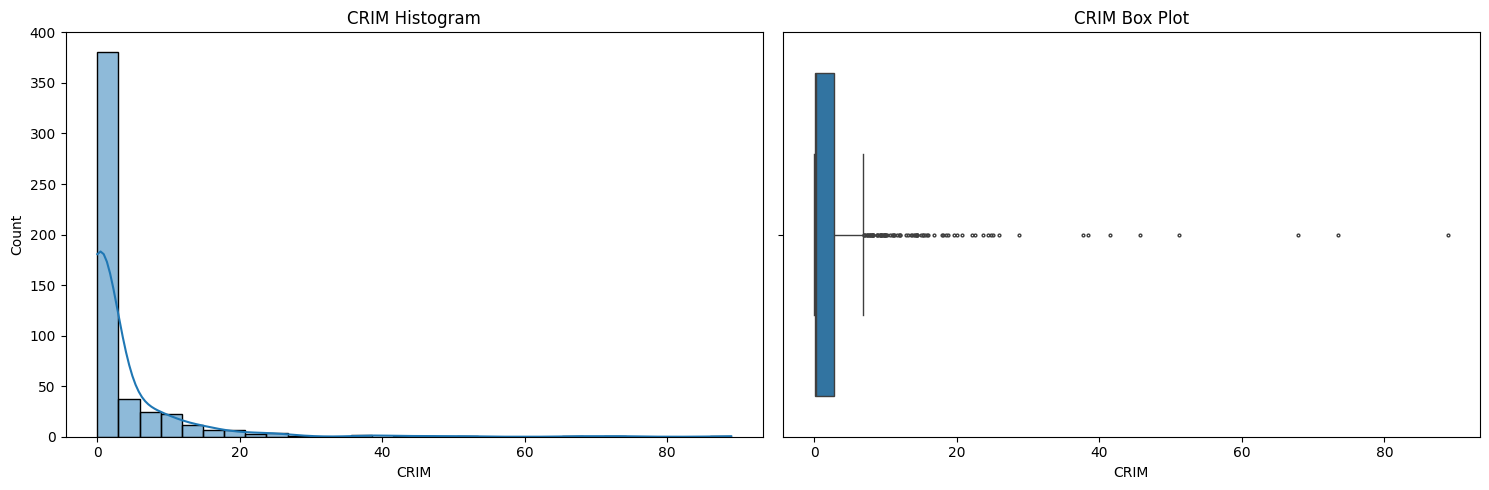

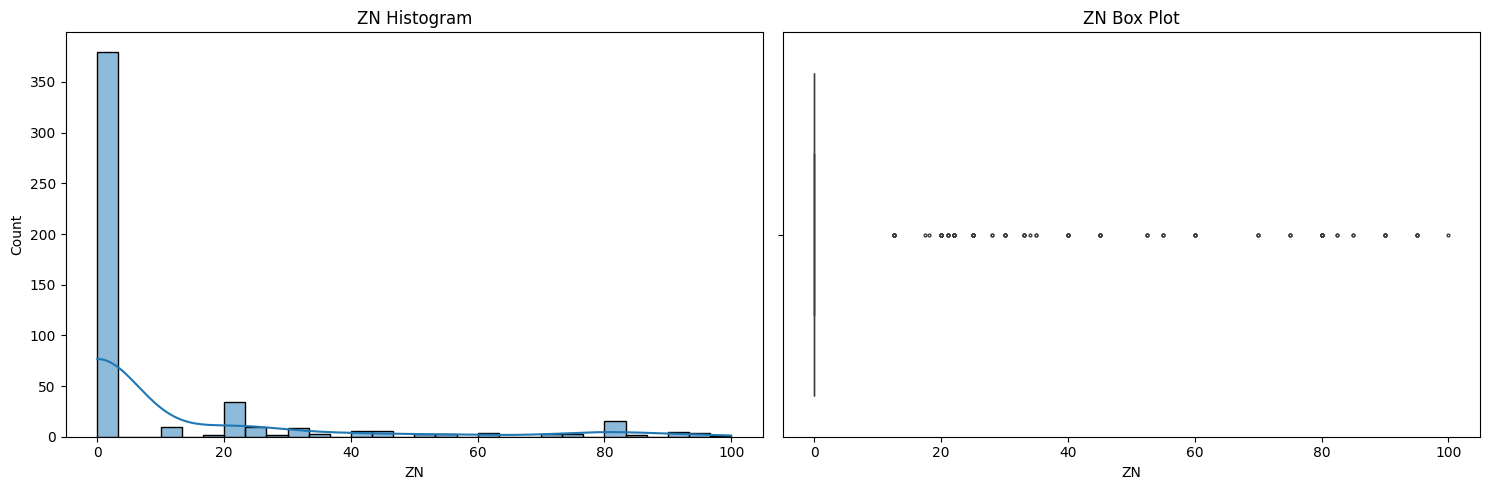

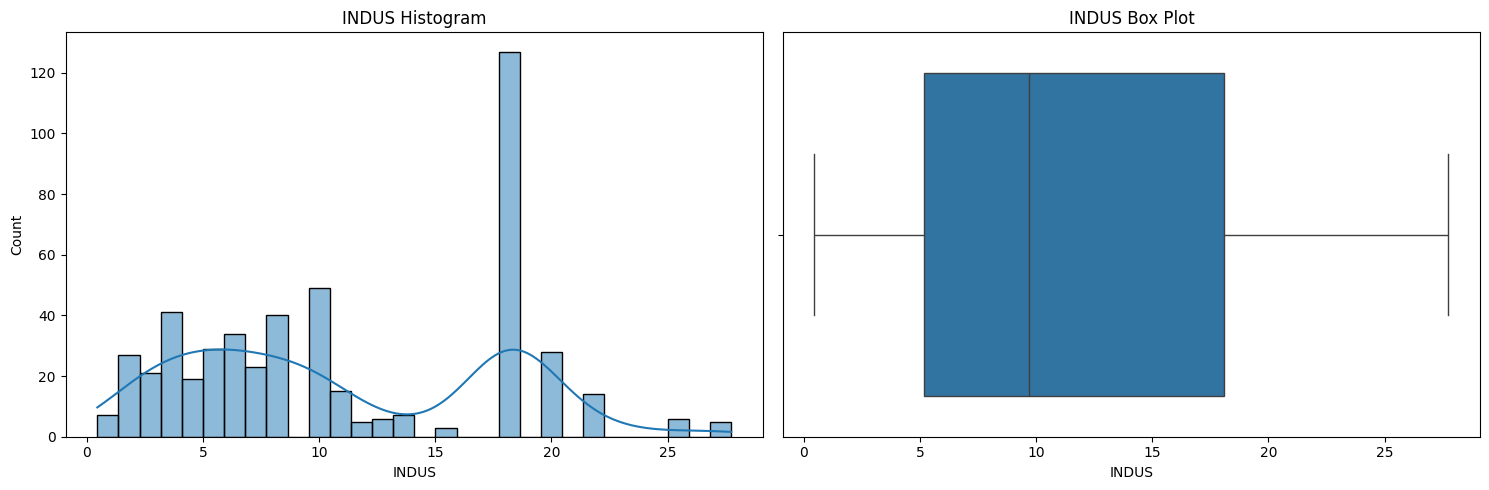

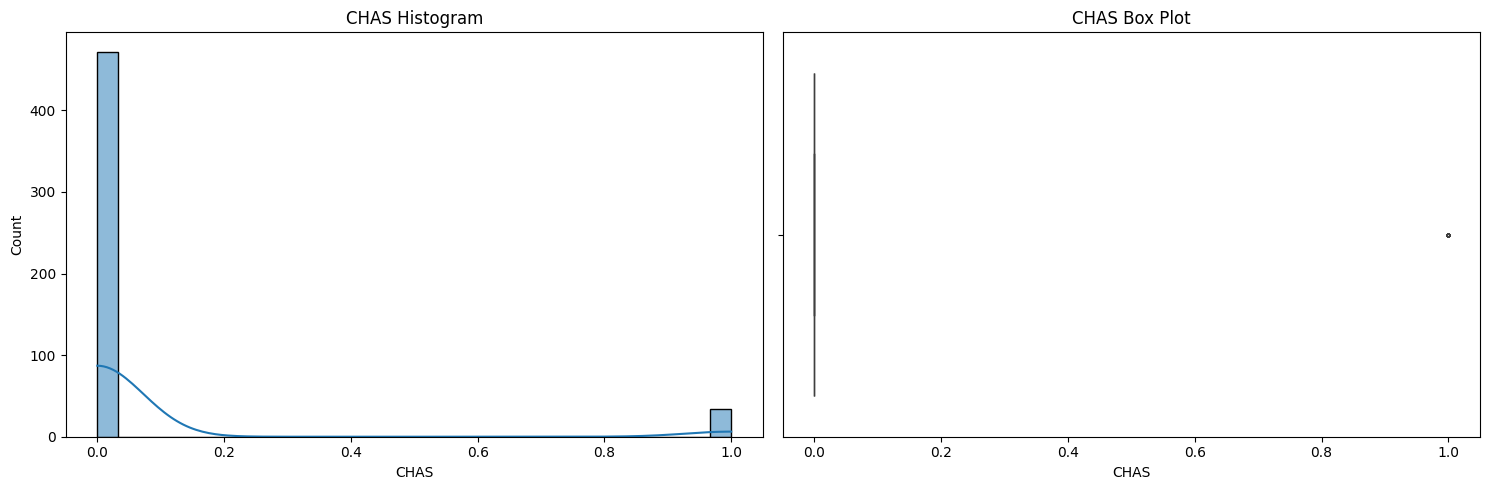

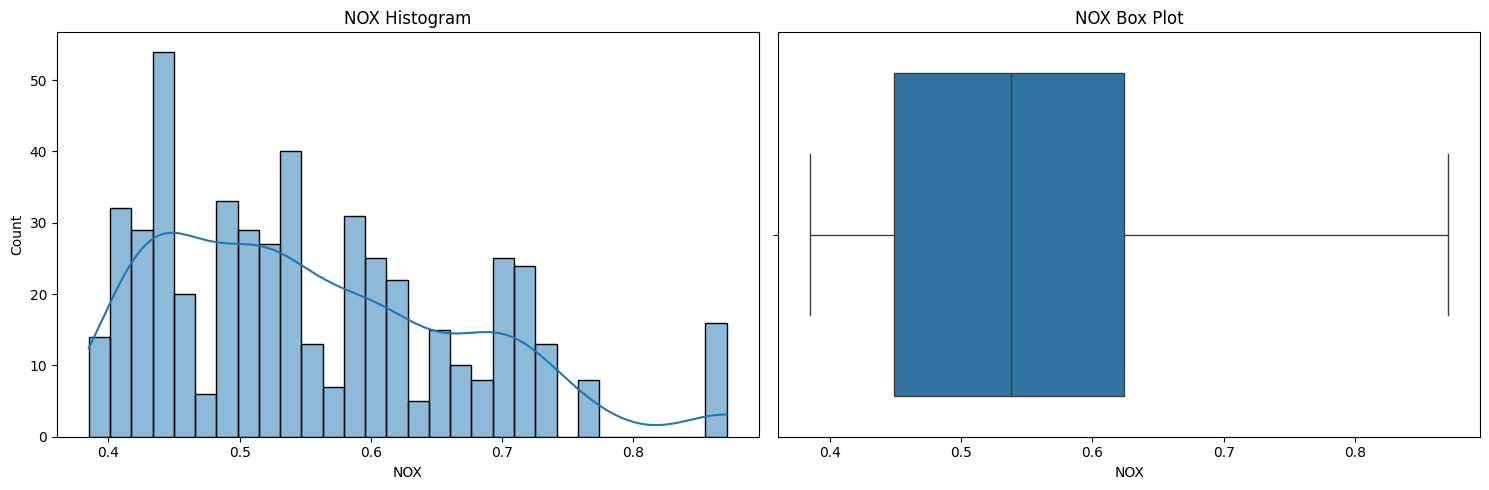

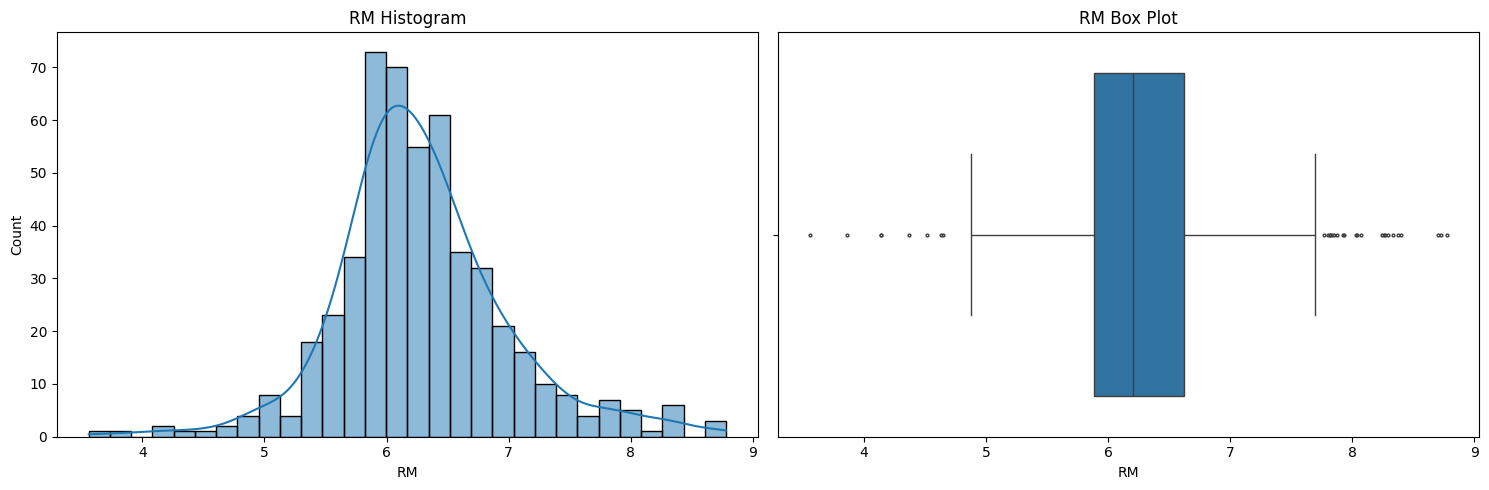

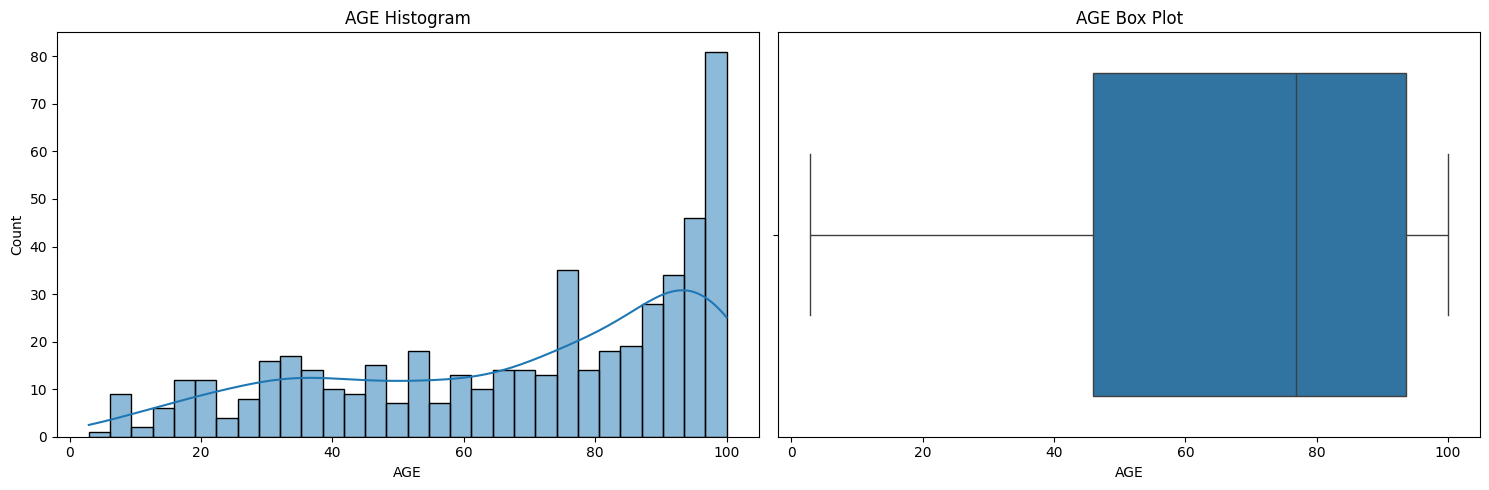

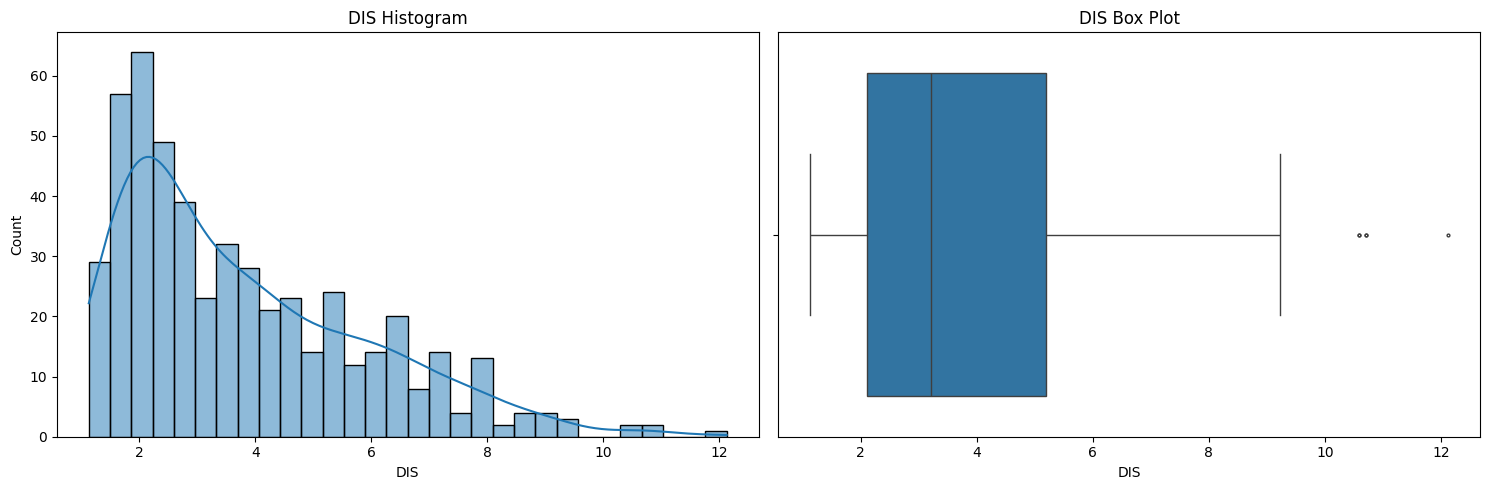

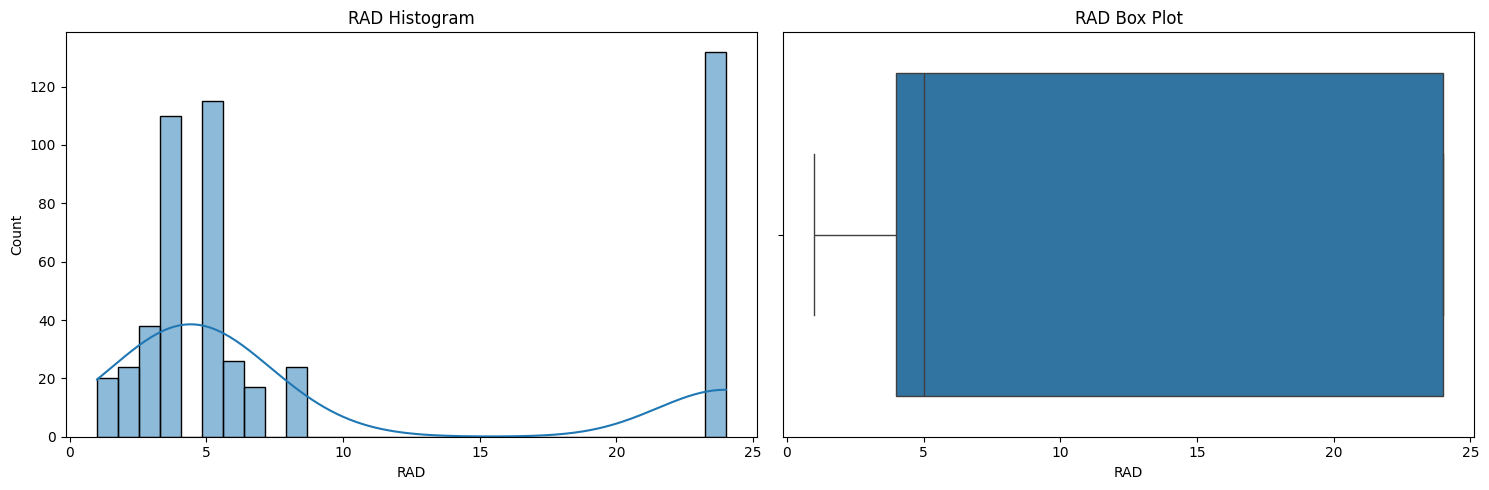

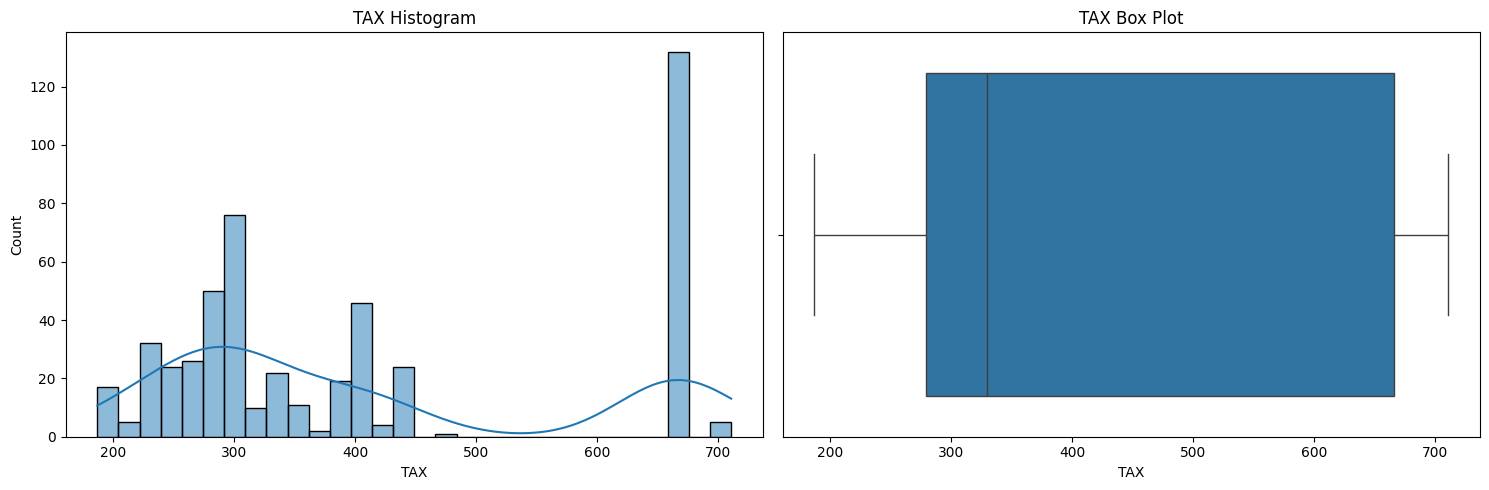

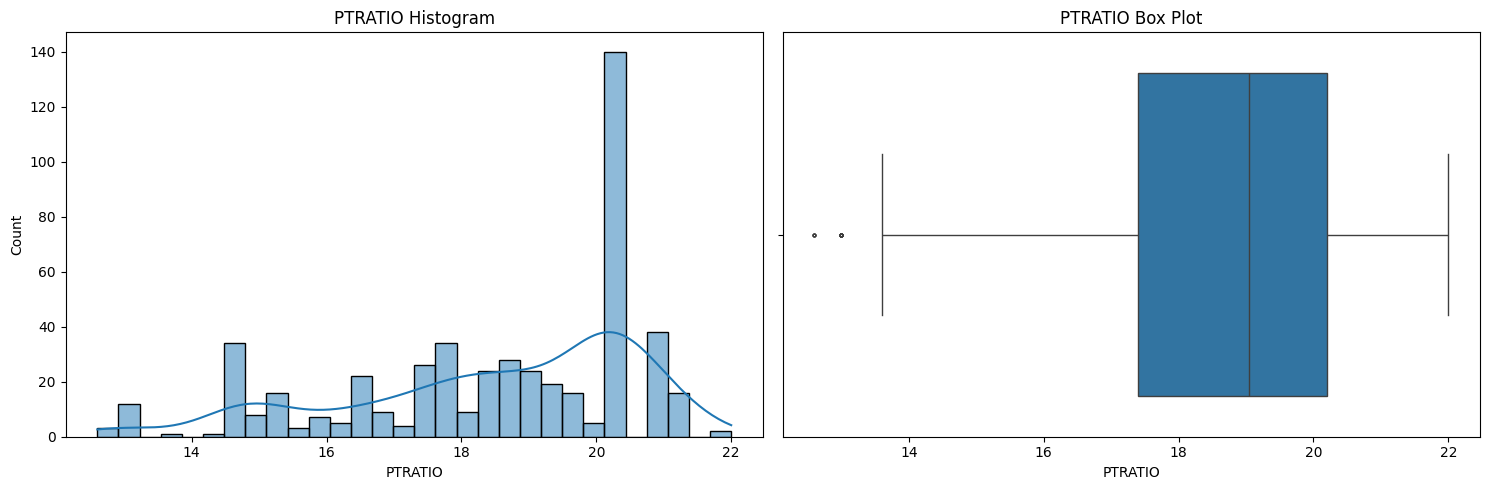

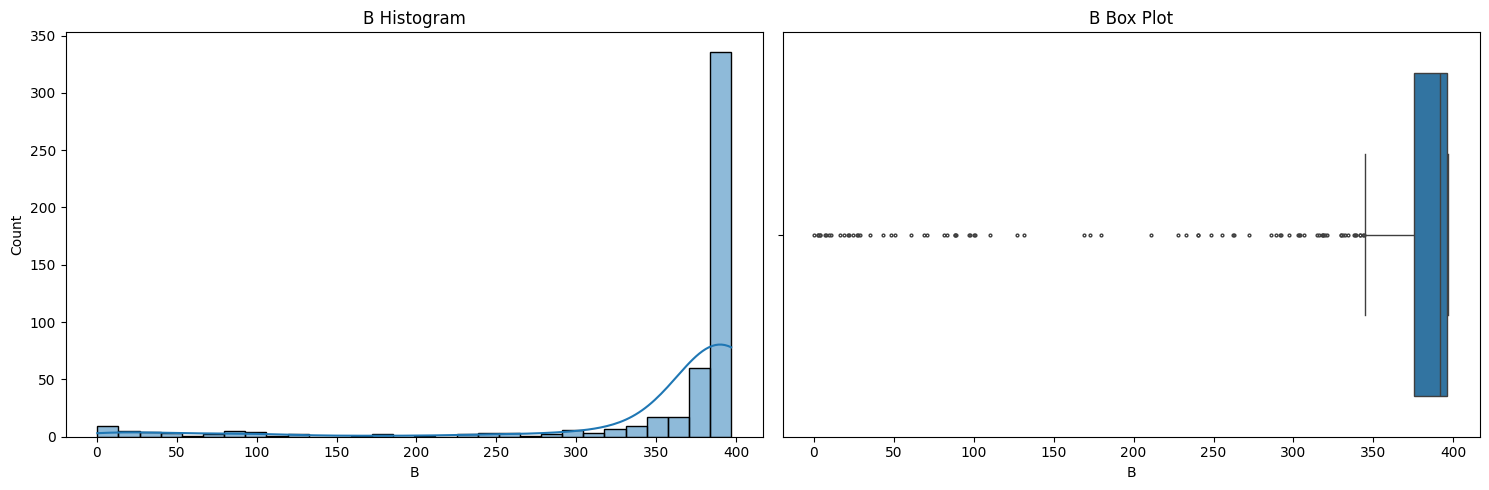

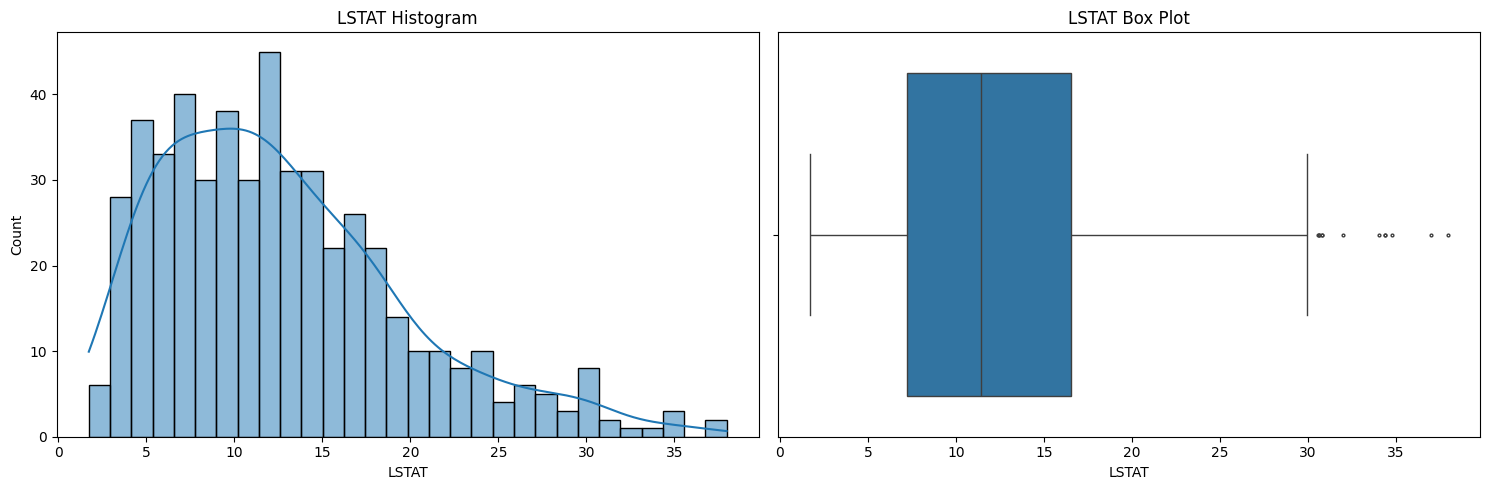

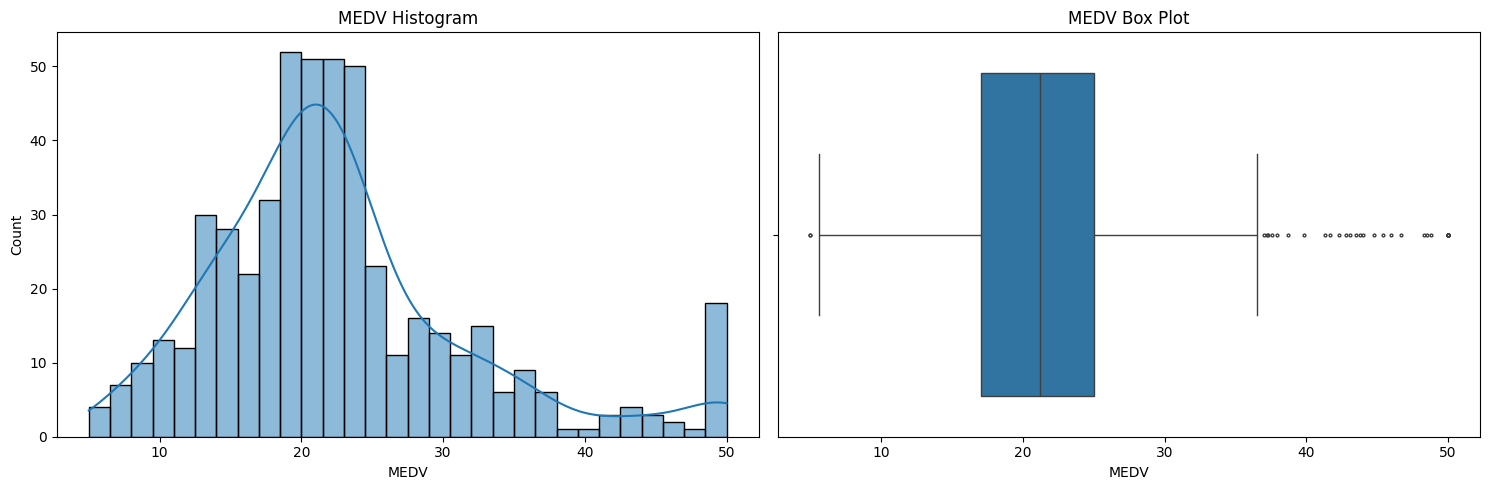

In [4]:
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} Histogram")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], fliersize=2)
    plt.title(f"{col} Box Plot")
    plt.tight_layout()
    plt.show()

# Handle Outliers

In [5]:
cols_to_handle = ['CRIM', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
for col in cols_to_handle:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

# Checking Heatmap

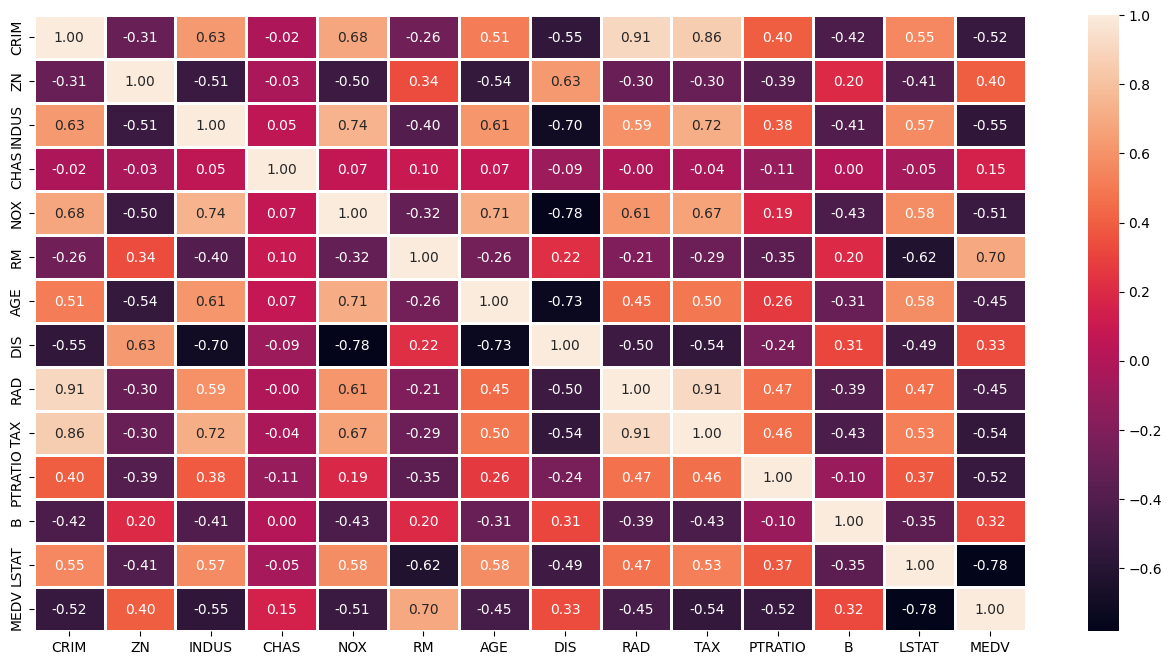

In [6]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=1)
plt.show()

### TAX and RAD are highly correlated (91%).
Although RAD has lower feature importance than TAX, removing RAD led to a slight decrease in prediction performance. I decided to keep both features.

# Prepare Data

In [55]:
X = df.drop(['MEDV', 'ZN', 'CHAS'], axis=1)
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Models



In [ ]:
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=210,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42
    ),
        "XGBoost": XGBRegressor(
        n_estimators=700,        
        max_depth=5,
        learning_rate=0.05,
        subsample=0.7,            
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ),
    "CatBoost": CatBoostRegressor(
        iterations=500,
        depth=5,
        learning_rate=0.05,
        verbose=0,
        random_state=42
    )
}

# Train and Evaluate Models


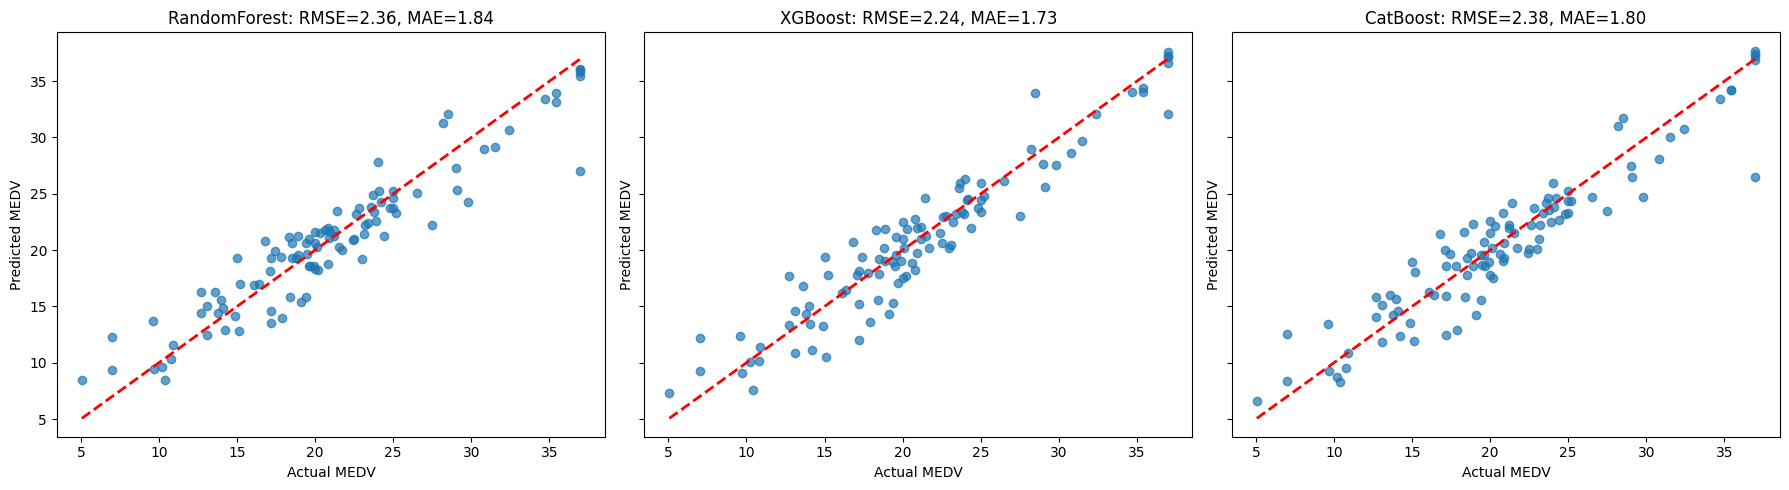

In [57]:
results = []

n_models = len(models)

fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({"Model": name, "RMSE": rmse, "MAE": mae})
    
    ax.scatter(y_test, y_pred, alpha=0.7)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    ax.set_xlabel("Actual MEDV")
    ax.set_ylabel("Predicted MEDV")
    ax.set_title(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}")

plt.tight_layout()
plt.show()

# Comparison Table


In [58]:
results_df = pd.DataFrame(results).sort_values("RMSE")
print("\nModel Comparison:")
print(results_df)


Model Comparison:
          Model      RMSE       MAE
1       XGBoost  2.240476  1.727841
0  RandomForest  2.359508  1.836405
2      CatBoost  2.383120  1.804934
